In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
import psycopg2
from collections import Counter 

In [2]:
table_cols = [('age_group', 'reporting_phu_city', 'cause_of_infection', 'gender', 'Resolved', 'Fatal', 'Special_Measure_Key')]
fact_table = []

def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        return psycopg2.connect(
            host="www.eecs.uottawa.ca",
            database="group_21",
            user="****",
            password="****",
            port="15432"
        )
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)


connection = connect()
print('***Connection established***')

cur = connection.cursor()
        
cur.execute('SELECT I.age_group, I.reporting_phu_city,\
            I.cause_of_infection, I.gender, F."Resolved",\
            F."Fatal", F."Special_Measure_Key" FROM fact_table_v2 as F\
            INNER JOIN individuals as I on I.individual_id = F."Individual_Key"')
rows = cur.fetchall()
fact_table = rows
print(fact_table[:10])

cur.close()
connection.close()
print('***Connection terminated***')

Connecting to the PostgreSQL database...
***Connection established***
[('40s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('30s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('90+', 'Toronto', 'OB', 'FEMALE', 'no', 'yes', 11), ('80s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('50s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('30s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('50s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('50s', 'Toronto', 'OB', 'MALE', 'yes', 'no', 11), ('20s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('80s', 'Toronto', 'NO KNOWN EPI LINK', 'FEMALE', 'yes', 'no', 2)]
***Connection terminated***


In [3]:
result_df = pd.DataFrame(fact_table, columns=["age_group", "reporting_phu_city", "cause_of_infection", 
                                               "gender", "Resolved","Fatal","Special_Measure_Key"])
#result_df.head()

### One Hot Encoding
##### Class = Age Group
- create 9 columns with boolean values and check for imbalance
- one hot encoding to turn into 0s and 1s and then more preprocessing to convert those to boolean values

##### Features
- City, Cause of Infection, Gender, Resolved, Fatal, Special Measures

In [4]:
new_result_df = pd.get_dummies(result_df, prefix=["age_group", "reporting_phu_city", "cause_of_infection", "gender", "Resolved", "Fatal"])
X = new_result_df.values
#new_result_df.head()

Special Measures is a bit more complicated so need to do some more processing. Using the sklearn library to handle the complications.

In [5]:
# Create Labeler and Encoder
labelencoder = LabelEncoder()
encoder = OneHotEncoder(dtype=int, handle_unknown='ignore')

In [6]:
# Assigning numerical values and storing in another column
new_result_df['Special_Measure_Key_Tmp'] = labelencoder.fit_transform(new_result_df['Special_Measure_Key'])
#new_result_df.head()

In [7]:
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(encoder.fit_transform(new_result_df[['Special_Measure_Key_Tmp']]).toarray())

In [8]:
#  merge with main df bridge_df on key values
new_result_df = new_result_df.join(enc_df)
new_result_df.rename(columns={6: "lockdown", 10: "stage 3 extended to toronto", 2: "Restart", 1: "Gatineau-Ottawa Travel Restriction", 3: "Parks Re-opened"},inplace = True)
new_result_df = new_result_df.drop(['Special_Measure_Key_Tmp'], axis=1)
#new_result_df.head()

In [9]:
new_result_df = new_result_df.drop(['Special_Measure_Key', 4, 5], axis=1)
#new_result_df.head()

### Undersampling

In [10]:
from collections import Counter 
Counter(new_result_df['age_group_20s'])

Counter({0: 13125, 1: 2131})

In [11]:
Counter(new_result_df['age_group_30s'])

Counter({0: 13219, 1: 2037})

In [12]:
Counter(new_result_df['age_group_40s'])

Counter({1: 2107, 0: 13149})

In [13]:
Counter(new_result_df['age_group_50s'])

Counter({0: 12859, 1: 2397})

In [14]:
Counter(new_result_df['age_group_60s'])

Counter({0: 13612, 1: 1644})

In [15]:
Counter(new_result_df['age_group_70s'])

Counter({0: 14135, 1: 1121})

In [16]:
Counter(new_result_df['age_group_80s'])

Counter({0: 13569, 1: 1687})

In [17]:
Counter(new_result_df['age_group_90+'])

Counter({0: 13973, 1: 1283})

In [18]:
Counter(new_result_df['age_group_<20'])

Counter({0: 14408, 1: 848})

All classes are highly imbalanced. It's even more clear by plotting 'age group 20s'.

(-1.1067402961074844,
 1.1022251644441523,
 -1.1065996248296672,
 1.1003142678490319)

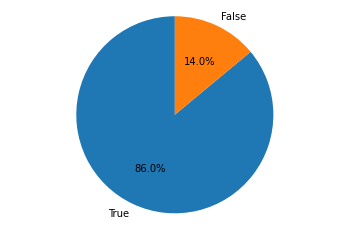

In [19]:
import matplotlib.pyplot as plt

labels = 'True', 'False'
sizes = [13125, 2131]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

#plt.show()

Therefore, it is likely if we train our model to classify 'age group 20s' on this dataset, during testing it will more often than not predict false.

In [20]:
from sklearn.utils import resample

df_majority = new_result_df[new_result_df.age_group_20s==False]
df_minority = new_result_df[new_result_df.age_group_20s==True]

df_majority_upsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2131,    # to match minority class
                                 random_state=42)

df_upsampled = pd.concat([df_minority, df_majority_upsampled])

#df_upsampled.age_group_20s.value_counts()

In [21]:
# put undersampling into function
def undersample(column_name):
  df_majority = new_result_df[new_result_df[column_name]==False]
  df_minority = new_result_df[new_result_df[column_name]==True]

  df_majority_upsampled = resample(df_majority, 
                                  replace=True,     # sample with replacement
                                  n_samples=len(df_minority.index),    # to match minority class
                                  random_state=42)

  df_upsampled = pd.concat([df_minority, df_majority_upsampled])

  print(df_upsampled[column_name].value_counts())

  return df_upsampled

In [22]:
df_age_group_20s = undersample("age_group_20s")
df_age_group_30s = undersample("age_group_30s")
df_age_group_40s = undersample("age_group_40s")
df_age_group_50s = undersample("age_group_50s")
df_age_group_60s = undersample("age_group_60s")
df_age_group_70s = undersample("age_group_70s")
df_age_group_80s = undersample("age_group_80s")
df_age_group_90 = undersample("age_group_90+")
df_age_group_20 = undersample("age_group_<20")

1    2131
0    2131
Name: age_group_20s, dtype: int64
1    2037
0    2037
Name: age_group_30s, dtype: int64
1    2107
0    2107
Name: age_group_40s, dtype: int64
1    2397
0    2397
Name: age_group_50s, dtype: int64
1    1644
0    1644
Name: age_group_60s, dtype: int64
1    1121
0    1121
Name: age_group_70s, dtype: int64
1    1687
0    1687
Name: age_group_80s, dtype: int64
1    1283
0    1283
Name: age_group_90+, dtype: int64
1    848
0    848
Name: age_group_<20, dtype: int64


### Less than 20

In [23]:
df_age_group_20.drop(['age_group_20s','age_group_30s','age_group_40s', 'age_group_50s', 'age_group_60s','age_group_70s', 'age_group_80s', 'age_group_90+', 'age_group_UNKNOWN',0], axis=1, inplace=True)
#Get the labels
y = df_age_group_20['age_group_<20']
df_age_group_20.drop(['age_group_<20'], axis=1, inplace=True)
X = df_age_group_20.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

#This step is to train our classifier based on the training data.
dt = DecisionTreeClassifier(criterion='entropy')

import time
t0= time.perf_counter()
dt.fit(X_train, y_train)
t1 = time.perf_counter() - t0
print("Accuracy score (training): {0:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(dt.score(X_test, y_test)))
print("Time to construct model ", t1)

from sklearn.metrics import classification_report
predictions = dt.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

r = export_text(dt, feature_names = df_age_group_20.columns.values.tolist())
print(r)


Training set Counter({0: 568, 1: 568}) 
Test set Counter({0: 280, 1: 280}) 
Accuracy score (training): 0.751
Accuracy score (testing): 0.752
Time to construct model  0.001961833999999385
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.65      0.72       280
           1       0.71      0.85      0.77       280

    accuracy                           0.75       560
   macro avg       0.76      0.75      0.75       560
weighted avg       0.76      0.75      0.75       560

|--- cause_of_infection_CC <= 0.50
|   |--- lockdown <= 0.50
|   |   |--- gender_UNSPECIFIED <= 0.50
|   |   |   |--- Parks Re-opened <= 0.50
|   |   |   |   |--- Gatineau-Ottawa Travel Restriction <= 0.50
|   |   |   |   |   |--- Resolved_yes <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Resolved_yes >  0.50
|   |   |   |   |   |   |--- Restart <= 0.50
|   |   |   |   |   |   |   |--- reporting_phu_city_Toronto <= 0.50
|   |   |   |  

In [24]:
from sklearn import tree
fig = plt.figure(figsize=(250,200))
_ = tree.plot_tree(dt, 
                   feature_names=df_age_group_20.columns.values.tolist(),  
                   
                   filled=True)
fig.savefig("decision_tree.png")

### Age group 20s

In [25]:
df_age_group_20s.drop(['age_group_30s', 'age_group_40s', 'age_group_50s', 'age_group_60s', 'age_group_70s', 'age_group_80s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN', 0], axis=1, inplace=True)

### We are done with pre-processing of our data. Next, we need to divide our data to training and testing sets.

In [26]:
#Get the labels
y = df_age_group_20s['age_group_20s']
df_age_group_20s.drop(['age_group_20s'], axis=1, inplace=True)
X = df_age_group_20s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({0: 1428, 1: 1427}) 
Test set Counter({1: 704, 0: 703}) 


## Now let us apply the DecisionTreeClassifier algorithm

In [27]:
#This step is to train our classifier based on the training data.
dt = DecisionTreeClassifier(criterion='entropy')

t0= time.perf_counter()
dt.fit(X_train, y_train)
t1 = time.perf_counter() - t0
print("Accuracy score (training): {0:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(dt.score(X_test, y_test)))
print("Time to construct model ", t1)

predictions = dt.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

Accuracy score (training): 0.662
Accuracy score (testing): 0.648
Time to construct model  0.0060973949999976185
Classification Report
              precision    recall  f1-score   support

           0       0.68      0.55      0.61       703
           1       0.63      0.74      0.68       704

    accuracy                           0.65      1407
   macro avg       0.65      0.65      0.65      1407
weighted avg       0.65      0.65      0.65      1407



In [28]:
r = export_text(dt, feature_names=df_age_group_20s.columns.values.tolist())
print(r)

|--- cause_of_infection_OB <= 0.50
|   |--- Fatal_no <= 0.50
|   |   |--- class: 0
|   |--- Fatal_no >  0.50
|   |   |--- lockdown <= 0.50
|   |   |   |--- cause_of_infection_NO KNOWN EPI LINK <= 0.50
|   |   |   |   |--- gender_FEMALE <= 0.50
|   |   |   |   |   |--- reporting_phu_city_Ottawa <= 0.50
|   |   |   |   |   |   |--- Parks Re-opened <= 0.50
|   |   |   |   |   |   |   |--- cause_of_infection_TRAVEL <= 0.50
|   |   |   |   |   |   |   |   |--- cause_of_infection_MISSING INFORMATION <= 0.50
|   |   |   |   |   |   |   |   |   |--- Gatineau-Ottawa Travel Restriction <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- gender_MALE <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- gender_MALE >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- Gatineau-Ottawa Travel Restriction >  0.50
|   |   |   |   |   |   |   |   |   |   |--- gender_UNSPECIFIED <= 0.50
|   |  

### Apply to 30s

In [29]:
df_age_group_30s.drop(['age_group_20s','age_group_40s', 'age_group_50s', 'age_group_60s', 'age_group_70s', 'age_group_80s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN',0], axis=1, inplace=True)

In [30]:
#Get the labels
y = df_age_group_30s['age_group_30s']
df_age_group_30s.drop(['age_group_30s'], axis=1, inplace=True)
X = df_age_group_30s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({1: 1365, 0: 1364}) 
Test set Counter({0: 673, 1: 672}) 


In [31]:
#This step is to train our classifier based on the training data.
dt = DecisionTreeClassifier(criterion='entropy')

t0= time.perf_counter()
dt.fit(X_train, y_train)
t1 = time.perf_counter() - t0
print("Accuracy score (training): {0:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(dt.score(X_test, y_test)))
print("Time to construct model ", t1)

predictions = dt.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

Accuracy score (training): 0.608
Accuracy score (testing): 0.590
Time to construct model  0.0035694940000041697
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.45      0.52       673
           1       0.57      0.73      0.64       672

    accuracy                           0.59      1345
   macro avg       0.60      0.59      0.58      1345
weighted avg       0.60      0.59      0.58      1345



In [32]:
r = export_text(dt, feature_names = df_age_group_30s.columns.values.tolist())
print(r)

|--- Fatal_no <= 0.50
|   |--- cause_of_infection_NO KNOWN EPI LINK <= 0.50
|   |   |--- class: 0
|   |--- cause_of_infection_NO KNOWN EPI LINK >  0.50
|   |   |--- gender_MALE <= 0.50
|   |   |   |--- class: 0
|   |   |--- gender_MALE >  0.50
|   |   |   |--- lockdown <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- lockdown >  0.50
|   |   |   |   |--- class: 0
|--- Fatal_no >  0.50
|   |--- cause_of_infection_OB <= 0.50
|   |   |--- cause_of_infection_MISSING INFORMATION <= 0.50
|   |   |   |--- gender_FEMALE <= 0.50
|   |   |   |   |--- cause_of_infection_NO KNOWN EPI LINK <= 0.50
|   |   |   |   |   |--- reporting_phu_city_Ottawa <= 0.50
|   |   |   |   |   |   |--- gender_MALE <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- gender_MALE >  0.50
|   |   |   |   |   |   |   |--- lockdown <= 0.50
|   |   |   |   |   |   |   |   |--- Gatineau-Ottawa Travel Restriction <= 0.50
|   |   |   |   |   |   |   |   |   |--- Parks Re-opened <= 0.50
|   |   

### Apply to 40s

In [33]:
df_age_group_40s.drop(['age_group_20s','age_group_30s','age_group_50s', 'age_group_60s', 'age_group_70s', 'age_group_80s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN',0], axis=1, inplace=True)

In [34]:
#Get the labels
y = df_age_group_40s['age_group_40s']
df_age_group_40s.drop(['age_group_40s'], axis=1, inplace=True)
X = df_age_group_40s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({1: 1412, 0: 1411}) 
Test set Counter({0: 696, 1: 695}) 


In [35]:
#This step is to train our classifier based on the training data.
dt = DecisionTreeClassifier(criterion='entropy')

t0= time.perf_counter()
dt.fit(X_train, y_train)
t1 = time.perf_counter() - t0
print("Accuracy score (training): {0:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(dt.score(X_test, y_test)))
print("Time to construct model ", t1)

predictions = dt.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

Accuracy score (training): 0.587
Accuracy score (testing): 0.545
Time to construct model  0.0034184360000040215
Classification Report
              precision    recall  f1-score   support

           0       0.55      0.52      0.53       696
           1       0.54      0.57      0.56       695

    accuracy                           0.54      1391
   macro avg       0.55      0.54      0.54      1391
weighted avg       0.55      0.54      0.54      1391



In [36]:
r = export_text(dt, feature_names = df_age_group_40s.columns.values.tolist())
print(r)

|--- Resolved_no <= 0.50
|   |--- cause_of_infection_OB <= 0.50
|   |   |--- gender_MALE <= 0.50
|   |   |   |--- Gatineau-Ottawa Travel Restriction <= 0.50
|   |   |   |   |--- Restart <= 0.50
|   |   |   |   |   |--- gender_GENDER DIVERSE <= 0.50
|   |   |   |   |   |   |--- lockdown <= 0.50
|   |   |   |   |   |   |   |--- reporting_phu_city_Toronto <= 0.50
|   |   |   |   |   |   |   |   |--- Parks Re-opened <= 0.50
|   |   |   |   |   |   |   |   |   |--- cause_of_infection_CC <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- cause_of_infection_CC >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- Parks Re-opened >  0.50
|   |   |   |   |   |   |   |   |   |--- cause_of_infection_NO KNOWN EPI LINK <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- cause_of_infection_NO KNOWN EPI LINK >  0.50
|   |   |   |   |   |   |   |   |   |  

### Age group 50s

In [37]:
df_age_group_50s.drop(['age_group_20s','age_group_30s','age_group_40s', 'age_group_60s', 'age_group_70s', 'age_group_80s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN',0], axis=1, inplace=True)
#Get the labels
y = df_age_group_50s['age_group_50s']
df_age_group_50s.drop(['age_group_50s'], axis=1, inplace=True)
X = df_age_group_50s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

#This step is to train our classifier based on the training data.
dt = DecisionTreeClassifier(criterion='entropy')

t0= time.perf_counter()
dt.fit(X_train, y_train)
t1 = time.perf_counter() - t0
print("Accuracy score (training): {0:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(dt.score(X_test, y_test)))
print("Time to construct model ", t1)

predictions = dt.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

r = export_text(dt, feature_names = df_age_group_50s.columns.values.tolist())
print(r)

Training set Counter({0: 1606, 1: 1605}) 
Test set Counter({1: 792, 0: 791}) 
Accuracy score (training): 0.586
Accuracy score (testing): 0.558
Time to construct model  0.003469522000003167
Classification Report
              precision    recall  f1-score   support

           0       0.59      0.38      0.46       791
           1       0.54      0.74      0.62       792

    accuracy                           0.56      1583
   macro avg       0.57      0.56      0.54      1583
weighted avg       0.57      0.56      0.54      1583

|--- Fatal_yes <= 0.50
|   |--- cause_of_infection_NO KNOWN EPI LINK <= 0.50
|   |   |--- gender_FEMALE <= 0.50
|   |   |   |--- Restart <= 0.50
|   |   |   |   |--- gender_MALE <= 0.50
|   |   |   |   |   |--- lockdown <= 0.50
|   |   |   |   |   |   |--- cause_of_infection_OB <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- cause_of_infection_OB >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- lockdow

### Age group 60s

In [38]:
df_age_group_60s.drop(['age_group_20s','age_group_30s','age_group_40s', 'age_group_50s', 'age_group_70s', 'age_group_80s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN',0], axis=1, inplace=True)
#Get the labels
y = df_age_group_60s['age_group_60s']
df_age_group_60s.drop(['age_group_60s'], axis=1, inplace=True)
X = df_age_group_60s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

#This step is to train our classifier based on the training data.
dt = DecisionTreeClassifier(criterion='entropy')

t0= time.perf_counter()
dt.fit(X_train, y_train)
t1 = time.perf_counter() - t0
print("Accuracy score (training): {0:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(dt.score(X_test, y_test)))
print("Time to construct model ", t1)

predictions = dt.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

r = export_text(dt, feature_names = df_age_group_60s.columns.values.tolist())
print(r)

Training set Counter({0: 1101, 1: 1101}) 
Test set Counter({0: 543, 1: 543}) 
Accuracy score (training): 0.599
Accuracy score (testing): 0.547
Time to construct model  0.0031238490000049524
Classification Report
              precision    recall  f1-score   support

           0       0.55      0.56      0.55       543
           1       0.55      0.54      0.54       543

    accuracy                           0.55      1086
   macro avg       0.55      0.55      0.55      1086
weighted avg       0.55      0.55      0.55      1086

|--- gender_MALE <= 0.50
|   |--- Parks Re-opened <= 0.50
|   |   |--- Resolved_yes <= 0.50
|   |   |   |--- cause_of_infection_CC <= 0.50
|   |   |   |   |--- lockdown <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- lockdown >  0.50
|   |   |   |   |   |--- gender_FEMALE <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- gender_FEMALE >  0.50
|   |   |   |   |   |   |--- cause_of_infection_NO KNOWN EPI LINK <= 0.50
|   | 

### Age group 70s

In [39]:
df_age_group_70s.drop(['age_group_20s','age_group_30s','age_group_40s', 'age_group_50s', 'age_group_60s', 'age_group_80s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN',0], axis=1, inplace=True)
#Get the labels
y = df_age_group_70s['age_group_70s']
df_age_group_70s.drop(['age_group_70s'], axis=1, inplace=True)
X = df_age_group_70s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

#This step is to train our classifier based on the training data.
dt = DecisionTreeClassifier(criterion='entropy')

t0= time.perf_counter()
dt.fit(X_train, y_train)
t1 = time.perf_counter() - t0
print("Accuracy score (training): {0:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(dt.score(X_test, y_test)))
print("Time to construct model ", t1)

predictions = dt.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

r = export_text(dt, feature_names = df_age_group_70s.columns.values.tolist())
print(r)

Training set Counter({0: 751, 1: 751}) 
Test set Counter({1: 370, 0: 370}) 
Accuracy score (training): 0.638
Accuracy score (testing): 0.558
Time to construct model  0.0028036380000031613
Classification Report
              precision    recall  f1-score   support

           0       0.56      0.55      0.55       370
           1       0.56      0.57      0.56       370

    accuracy                           0.56       740
   macro avg       0.56      0.56      0.56       740
weighted avg       0.56      0.56      0.56       740

|--- Fatal_yes <= 0.50
|   |--- cause_of_infection_CC <= 0.50
|   |   |--- cause_of_infection_NO KNOWN EPI LINK <= 0.50
|   |   |   |--- gender_FEMALE <= 0.50
|   |   |   |   |--- gender_GENDER DIVERSE <= 0.50
|   |   |   |   |   |--- lockdown <= 0.50
|   |   |   |   |   |   |--- gender_UNSPECIFIED <= 0.50
|   |   |   |   |   |   |   |--- cause_of_infection_TRAVEL <= 0.50
|   |   |   |   |   |   |   |   |--- cause_of_infection_OB <= 0.50
|   |   |   |   |   |

### Age group 80s

In [40]:
df_age_group_80s.drop(['age_group_20s','age_group_30s','age_group_40s', 'age_group_50s', 'age_group_60s', 'age_group_70s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN',0], axis=1, inplace=True)
#Get the labels
y = df_age_group_80s['age_group_80s']
df_age_group_80s.drop(['age_group_80s'], axis=1, inplace=True)
X = df_age_group_80s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

#This step is to train our classifier based on the training data.
dt = DecisionTreeClassifier(criterion='entropy')

t0= time.perf_counter()
dt.fit(X_train, y_train)
t1 = time.perf_counter() - t0
print("Accuracy score (training): {0:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(dt.score(X_test, y_test)))
print("Time to construct model ", t1)

predictions = dt.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

r = export_text(dt, feature_names = df_age_group_80s.columns.values.tolist())
print(r)

Training set Counter({1: 1130, 0: 1130}) 
Test set Counter({0: 557, 1: 557}) 
Accuracy score (training): 0.754
Accuracy score (testing): 0.737
Time to construct model  0.004746724000000313
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.61      0.70       557
           1       0.69      0.86      0.77       557

    accuracy                           0.74      1114
   macro avg       0.75      0.74      0.73      1114
weighted avg       0.75      0.74      0.73      1114

|--- cause_of_infection_OB <= 0.50
|   |--- Fatal_no <= 0.50
|   |   |--- gender_FEMALE <= 0.50
|   |   |   |--- reporting_phu_city_Toronto <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- reporting_phu_city_Toronto >  0.50
|   |   |   |   |--- Parks Re-opened <= 0.50
|   |   |   |   |   |--- cause_of_infection_TRAVEL <= 0.50
|   |   |   |   |   |   |--- cause_of_infection_CC <= 0.50
|   |   |   |   |   |   |   |--- cause_of_infection_NO KNOWN EPI LINK

### Age group 90s

In [41]:
df_age_group_90.drop(['age_group_20s','age_group_30s','age_group_40s', 'age_group_60s', 'age_group_70s', 'age_group_80s', 'age_group_50s','age_group_<20', 'age_group_UNKNOWN',0], axis=1, inplace=True)
#Get the labels
y = df_age_group_90['age_group_90+']
df_age_group_90.drop(['age_group_90+'], axis=1, inplace=True)
X = df_age_group_90.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

#This step is to train our classifier based on the training data.
dt = DecisionTreeClassifier(criterion='entropy')

t0= time.perf_counter()
dt.fit(X_train, y_train)
t1 = time.perf_counter() - t0
print("Accuracy score (training): {0:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(dt.score(X_test, y_test)))
print("Time to construct model ", t1)

predictions = dt.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

r = export_text(dt, feature_names = df_age_group_90.columns.values.tolist())
print(r)

Training set Counter({1: 860, 0: 859}) 
Test set Counter({0: 424, 1: 423}) 
Accuracy score (training): 0.804
Accuracy score (testing): 0.789
Time to construct model  0.002652439000002005
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       424
           1       0.73      0.91      0.81       423

    accuracy                           0.79       847
   macro avg       0.81      0.79      0.79       847
weighted avg       0.81      0.79      0.79       847

|--- cause_of_infection_OB <= 0.50
|   |--- Fatal_yes <= 0.50
|   |   |--- reporting_phu_city_Toronto <= 0.50
|   |   |   |--- class: 0
|   |   |--- reporting_phu_city_Toronto >  0.50
|   |   |   |--- cause_of_infection_MISSING INFORMATION <= 0.50
|   |   |   |   |--- lockdown <= 0.50
|   |   |   |   |   |--- cause_of_infection_NO KNOWN EPI LINK <= 0.50
|   |   |   |   |   |   |--- Parks Re-opened <= 0.50
|   |   |   |   |   |   |   |--- Gatineau-Ottawa Travel